In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob
from pydub import AudioSegment
import pdb
import librosa
import librosa.display

In [2]:
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")

In [3]:
def get_mel_forDS(save_dir, source_dir, sr, n_fft, hop_length):

    data, sr = librosa.load(source_dir, sr=sr)
    S_F = librosa.stft(data, n_fft=n_fft, hop_length=hop_length)
    
    # 振幅を取得
    amp = np.abs(S_F)

    # パワーに変換（振幅を二乗する）
    P = amp ** 2

    # スペクトログラムから、メル周波数のスペクトログラムを求める
    mel_S = librosa.feature.melspectrogram(S=P, sr=sr)

    log_after = librosa.power_to_db(mel_S)

    # Pytorch Conv2Dのinputのshapeは (データ数, Channel, Height, Width)でありメルスペクトログラムもこれに合わせる
    mel_dim_ex = log_after[np.newaxis, :, : ]  

    np.save(save_dir + source_dir.split("/")[-1].split(".")[0] , mel_dim_ex)

In [6]:
npy_files = sorted( glob.glob('../data/train_mel/*.npy') )
wav_files = sorted( glob.glob('../data/train_trim/*.wav') )

### npyが作られていないときにのみ実行する。
if len(npy_files) != len(wav_files):

    save_dir = "../data/train_mel/"
    if not os.path.isdir(save_dir):
            os.makedirs(save_dir)

    target_dir = "../data/music_wav/"
    SR = 44100
    N_FFT = 1024
    HOP_LENGTH = 1024

    for i in tqdm(range( len(wav_files)) ):
        wav_file = wav_files[i]
        get_mel_forDS(save_dir, wav_file, SR, N_FFT, HOP_LENGTH)

100%|██████████| 7178/7178 [10:50<00:00, 11.04it/s]


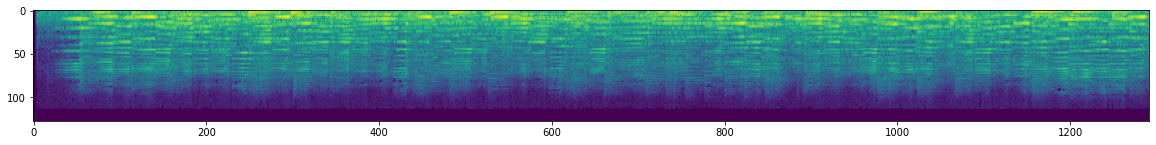

In [25]:
i = np.load('../data/train_mel/0_0.npy')
plt.figure(figsize=(20,50))
plt.imshow(i[0])

In [11]:
4410*30/128

1033.59375

In [22]:
def trans_quare_npy(save_dir, source_dir, sr, n_fft, hop_length):


    path_n = source_dir.split("/")[-1].split(".")[0] + ".npy"
    
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
        
    mel_numpy = np.load(source_dir)
    
    mel_adj = np.zeros( (1,128,128) )
    
    if mel_numpy.shape[-1] < 128:
        start = int( (128 - mel_numpy.shape[-1]) / 2 )
        end = start + mel_numpy.shape[-1]
        mel_adj[:,:,start:end] = mel_numpy

    elif mel_numpy.shape[-1] > 128:    
        mel_adj = mel_numpy[:,:,1:129]
        
    else:
        mel_adj = mel_numpy

    np.save(save_dir + path_n.split("/")[-1] , mel_adj)

In [23]:
SR = 44100
N_FFT = 1024
HOP_LENGTH = 1024
npy_files = sorted( glob.glob('../data/train_mel/*.npy') )
npy_files_preprocessed = sorted( glob.glob('../data/train_mel_sqaure/*.npy') )
save_dir = '../data/train_mel_sqaure/'

### 正方化されていないnpyが作られていないときにのみ実行する。
if len(npy_files_preprocessed) != len(npy_files):

    for i in tqdm( range(len(npy_files)) ):
        trans_quare_npy(save_dir, npy_files[i], SR, N_FFT, HOP_LENGTH)


else:
    None

100%|██████████| 7178/7178 [00:24<00:00, 292.76it/s]


In [44]:
train_mel_path = sorted( glob.glob('../data/train_mel_square/*.npy') )

music_file_ls = []
artist_id_ls = []

for txt in train_mel_path:

    music_file = txt.split("/")[-1].split("_")[0]
    music_file_ls.append( str(music_file) )
    filename = music_file+".mp3"

    artist_id_ls.append(train_df[ train_df["filename"] == filename]["artist_id"].values[-1])

In [45]:
df_train_npy_path = pd.DataFrame({
    "filename": music_file_ls,
    "artist_id": artist_id_ls,
    "npy_path": train_mel_path,
})
df_train_npy_path.to_csv("../output/train_npy.csv", index=False)

In [47]:
npy_files = sorted( glob.glob('../data/test_mel/*.npy') )
wav_files = sorted( glob.glob('../data/test_trim/*.wav') )
### npyが作られていないときにのみ実行する。

if len(npy_files) != len(wav_files):

    save_dir = "../data/test_mel/"
    if not os.path.isdir(save_dir):
            os.makedirs(save_dir)

    target_dir = "../data/test_trim/"
    SR = 44100
    N_FFT = 1024
    HOP_LENGTH = 1024

    for i in tqdm(range( len(wav_files)) ):
        wav_file = wav_files[i]
        get_mel_forDS(save_dir, wav_file, SR, N_FFT, HOP_LENGTH)

100%|██████████| 1382/1382 [22:48<00:00,  1.01it/s]


In [48]:
SR = 44100
N_FFT = 1024
HOP_LENGTH = 1024

npy_files = sorted( glob.glob('../data/test_mel/*.npy'))
npy_files_preprocessed = sorted( glob.glob('../data/test_mel_sqaure/*.npy') )
save_dir = '../data/test_mel_sqaure/'

### 正方化されていないnpyが作られていないときにのみ実行する。
if len(npy_files_preprocessed) != len(npy_files):

    for i in tqdm( range(len(npy_files)) ):
        trans_quare_npy(save_dir, npy_files[i], SR, N_FFT, HOP_LENGTH)

else:
    None

100%|██████████| 1382/1382 [00:01<00:00, 1141.05it/s]


In [49]:
npy_files_preprocessed = sorted(glob.glob('../data/test_mel_sqaure/*.npy') )

music_file_ls = []

for txt in npy_files_preprocessed:

    music_file = txt.split("/")[-1].split("_")[0]
    music_file_ls.append( str(music_file) )


In [50]:
df_test_wave_path = pd.DataFrame({
    "filename": music_file_ls,
    "npy_path": npy_files_preprocessed
})
df_test_wave_path.to_csv("../output/test_npy.csv", index=False)